# Homework 09

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, TimeDistributed, LSTM, GlobalAvgPool2D, AbstractRNNCell, MaxPooling2D, RNN
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tqdm
# magic line only needed in jupyter notebooks!
%reload_ext tensorboard

C:\Users\berit\AppData\Local\Continuum\miniconda3\envs\iannwtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dowloading Data for the Task from the Quick, Draw! Dataset

In [2]:
import os
import glob
#import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [7]:
# skip this cell if you already downloaded the data/you have the folder containing the data

# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]
# We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

141545 images to train on


In [5]:
# load images from newly created local folder
images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# amount of images for training
train_images = images[:10000]
# subset of the images for testing
test_images = images[15000:17500]

141545 images to train on


## Assignment 2: GANs

### 2.1 Prepare the Data

In [6]:
def data_preprocessing(raw_data):
    # create tf dataset out of numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices(raw_data)
    # reshap from (1, 784) to shape (28,28,1)
    dataset = dataset.map(lambda img: tf.reshape(img, (28,28,1)))
    # normalization of tensors
    dataset = dataset.map(lambda img: tf.image.per_image_standardization(img))
    # cache, shuffle, batch, prefetch
    dataset = dataset.cache().shuffle(1000).batch(32).prefetch(20)
    
    return dataset  

In [7]:
train_ds = data_preprocessing(train_images)
test_ds = data_preprocessing(test_images)

In [8]:
# check shape of the data   
list(train_ds.as_numpy_iterator())[1]
np.shape(list(train_ds.as_numpy_iterator())[1])

(32, 28, 28, 1)

In [19]:
def print_image(dataset):
    # get an image from the dataset
    img = next(iter(dataset))

    # get the first image from the batch
    img = img[0]

    # Remove the extra dimension
    #img = tf.squeeze(img, axis=-1)

    # plot the image
    plt.imshow(img)
    plt.show()

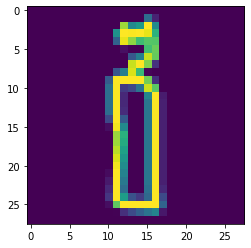

In [20]:
# visualize how a data point looks like 
print_image(train_ds)

### 2.2 The GAN Model

In [23]:
class Discriminator(tf.keras.Model):
    
    # perform downsampling and output a vector of probabilities indicating whether the input was fake or real
    # basically just like a CNN architecture for a binary classification task
    def __init__(self):
        
        super().__init__()
        
        # list of all layers to iterate through during call
        self.layer_list = []
        
        # layers
        self.layer_list.append(Conv2D(filters=24, kernel_size=3, padding='same', activation='relu'))
        self.layer_list.append(tf.keras.layers.BatchNormalization())
        #self.layer_list.append(tf.keras.layers.Dropout(0.2))
        self.layer_list.append(Conv2D(filters=24, kernel_size=3, padding='same', activation='relu'))
        self.layer_list.append(MaxPooling2D(pool_size=2, strides=2))

        self.layer_list.append(Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'))
        self.layer_list.append(tf.keras.layers.BatchNormalization())
        #self.layer_list.append(tf.keras.layers.Dropout(0.2))
        self.layer_list.append(Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'))
        self.layer_list.append(GlobalAvgPool2D())
        
        # a Dense layer with a single neuron in the end
        self.layer_list.append(Dense(1, activation='sigmoid'))
        
    # call funtion
    # training flag to use certain optimization and regularization techniques -> BatchNorm and Dropout
    @tf.function
    def call(self, x, training = False):
        for layer in self.layer_list:
            x = layer(x, training=training)
        return x
    

In [24]:
class Generator(tf.keras.Model):
    
    # takes a random point from the latent space and returns a generated image
    def __init__(self):
        
        super().__init__()
        
        # list of all layers to iterate through during call
        self.layer_list = []
        
        # layers
        # latent space (size adjustable, but start with 100) comes as a 1d vector
        self.layer_list.append(Dense(64, activation='relu', input_shape=(100,)))
        # reshape such that we have a 2D image
        self.layer_list.append(tf.keras.layers.Reshape((8,8,2)))
        
        # convolutional layers with upsampling in between and batch normalization/dropout
        self.layer_list.append(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
        self.layer_list.append(tf.keras.layers.BatchNormalization())
        #self.layer_list.append(tf.keras.layers.Dropout(0.2))
        # upsampling technique (Conv2DTranspose) - even-sized kernels in transposed convolutions
        self.layer_list.append(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, padding='same', activation='relu'))
        self.layer_list.append(Conv2D(filters=48, kernel_size=3, padding='same', activation='relu'))
        self.layer_list.append(tf.keras.layers.BatchNormalization())
        #self.layer_list.append(tf.keras.layers.Dropout(0.2))
        
        # in the last layer, perform a convolution with 1 feature map and tanh activation
        self.layer_list.append(Conv2D(filters=1, kernel_size=3, padding='same', activation='tanh'))
          
        
    # call funtion
    # training flag to use certain optimization and regularization techniques -> BatchNorm and Dropout
    @tf.function
    def call(self, x, training = False):
        for layer in self.layer_list:
            x = layer(x, training=training)
        return x

In [ ]:
class GAN(tf.keras.Model):
    
    def __init__(self):
        
        super().__init__()
        # optimzer, metrics, loss
        self.optimizer = tf.keras.optimizers.Adam()

        self.metrics_list = [
                        tf.keras.metrics.Mean(name="generator_loss"),
                        tf.keras.metrics.Mean(name="discriminator_loss"),
                        tf.keras.metrics.BinaryAccuracy(name="discriminator_acc") 
                       ]

        self.loss_function = tf.keras.losses.BinaryCrossentropy()
        
        self.discriminator = Discriminator() 
        self.generator = Generator() 

        
    # call funtion
    @tf.function
    def call(self, x, training=False):
        x = self.generator(x) 
        x = self.discriminator(x)
        return x
    
    # metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model

    # reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
    
    # train step method
    @tf.function
    def train_step(self, data):
        
        # create random noise = input to generator; size of noise vector is the size of latent space 
        noise = tf.random.normal((100,)) #????
        
        # calculate and backpropagate gradients
        with tf.GradientTape() as tape:
            
            # discriminator sees a batch of true images and a batch of the generated images
            generated_images = self.generator(noise, training =True)
            true_images = data
            # predictions
            output_generated = self.discriminator(generated_images, training=True)
            output_true = self.discriminator(true_images, training=True)
            # losses 
            # TO DO !!!!!!!!!!
            '''
            Compute the binary cross entropy between the generator’s output on fake images and all labels = 0. 
            Similarly, compute the BCE between the generator’s output on the real images and all labels = 1. 
            Add them both to receive the resulting loss of the discriminator.
            tf.ones like() and tf.zeros like() could be helpful for creating the true labels as a comparison.
            
            '''
            # loss of the discriminator is based on how well the discriminator detected fake images as fake and real images as real
            loss_discriminator =
            # loss of the generator is estimated by how well the generator was able to fool the discriminator
            loss_generator = 
            
            # accuracy of discriminator? 
            acc_discriminator = 
            
        
        # calculate gradients for both based on respective loss
        gradients_generator = tape.gradient(loss_generator, self.trainable_variables)
        gradients_discriminator = tape.gradient(loss_discriminator, self.trainable_variables)
        
        # apply optimizer for both 
        # do I need to initialize two individual optimizers before? 
        self.optimizer.apply_gradients(zip(gradients_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_discriminator, self.discriminator.trainable_variables))
        
        # update metrics
        self.metrics[0].update_state(loss_generator)
        self.metrics[1].update_state(loss_discriminator)
        self.metrics[2].update_state(acc_discriminator)
        
        # Return a dictionary mapping metric names to current value to keep track of training
        d = {m.name: m.result() for m in self.metrics}
        return d

    @tf.function
    def test_step(self, data):
        
        # TO DO !!!!!!!
        
        # same as in training but without backpropagating
        # ? 
        # For evaluation, you should therefore create some random latent vectors before training and feed them 
        # through the generator regularly. You can plot the resulting images to evaluate training.
        # ? 

### 2.3 Training

* visualize your training matrices as well as generate candle images using a random seed to assert the visual quality of your GAN
* start with 10 epochs
